In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
import pyvista as pv
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from scipy.stats import mannwhitneyu

mpl_config = pd.read_csv('../../mpl_config.csv').to_dict(orient='records')[0]

mpl.rcParams.update(mpl_config)

In [3]:
def standardize(M) :   
    """ Standardization by column for 2D matrices """
    
    M_copy = np.copy(M)
    M_copy = M_copy.astype(float)
    for j in range(np.shape(M)[1]) :
        if np.std(M[:,j]) != 0 :
            M_copy[:,j] = (M[:,j].astype(float) - float(np.mean(M[:,j])))/float(np.std(M[:,j]))
        else : 
            M_copy[:,j] = M[:,j].astype(float) - float(np.mean(M[:,j]))
            
    return M_copy


def produce_trial_index(d) :
    """Produce a dictionnary of trial indices corresponding to each label."""
    
    trial_idx = None
    
    go_hit_idx = (d['Choice'] == 1)&(d['Category ID'] == 2)&(d['Context'] == 0)
    go_error_idx = (d['Choice'] == 1)&(d['Category ID'] == 1)&(d['Context'] == 0)

    nogo_hit_idx = (d['Choice'] == -1)&(d['Category ID'] == 1)&(d['Context'] == 0)
    nogo_error_idx = (d['Choice'] == -1)&(d['Category ID'] == 2)&(d['Context'] == 0)

    right_hit_idx = (d['Choice'] == 1) & (d['Category ID'] == 2)&(d['Context'] == 1)
    left_hit_idx = (d['Choice'] == -1) & (d['Category ID'] == 1)&(d['Context'] == 1)

    right_error_idx = (d['Choice'] == 1) & (d['Category ID'] == 1)&(d['Context'] == 1)
    left_error_idx = (d['Choice'] == -1) & (d['Category ID'] == 2)&(d['Context'] == 1)

    # Snooze : The animal did not respond in the 2AFC paradigm.
    snooze_right_idx = (d['Choice'] == 0)&(d['Category ID'] == 2)&(d['Context'] == 1)
    snooze_left_idx = (d['Choice'] == 0)&(d['Category ID'] == 1)&(d['Context'] == 1)

    trial_idx = {'Go / Go : Hit' : go_hit_idx, 'Go / Nogo : Miss':nogo_error_idx, 'NoGo / NoGo : CR' : nogo_hit_idx , \
              'NoGo / Go : FA' : go_error_idx,  'Left / Left':left_hit_idx, 'Left / Right':left_error_idx, 'Left / Snooze':snooze_left_idx, \
           'Right / Right':right_hit_idx, 'Right / Left':right_error_idx, 'Right / Snooze':snooze_right_idx}

    return trial_idx

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2, directed = False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    delta = np.arccos(np.dot(v1_u, v2_u))*180/np.pi

    if not directed : 
        if delta > 90 :
            delta = 180 - delta
    return delta



def set_color(bplot,colors) :
    """Method to render box plots"""
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        #patch.set_alpha(0.4)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.8)

    for median, color in zip(bplot['medians'], colors):
        median.set_color(color)
        median.set_linewidth(5)
        median.set_alpha(1)

    
    for mean, color in zip(bplot['means'], colors):
        mean.set_color(color)
        mean.set_alpha(0.5)
        mean.set_linewidth(1.5)

    for whisk in bplot['whiskers']:
        whisk.set_linewidth(1.8)

    for caps in bplot['caps']:
        caps.set_linewidth(1.8)

def smooth(x,y,nb_point) :
    """Smooth a (x,y) serie by inserting nb_point with spline interpolation"""   
    x_smooth = np.linspace(np.min(x), np.max(x), nb_point) 
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    return x_smooth, y_smooth

In [1]:
## Importing data and models

with open('../DATA/Dataframes/df_pseudo.pickle', 'rb') as f:
    merged_data = pickle.load(f)

with open('../Pseudo_pop/Models/pca_notime.pickle', 'rb') as f:
    pca1 = pickle.load(f)

with open('../Pseudo_pop/Models/pca_time.pickle', 'rb') as f:
    pca2 = pickle.load(f)


files = ['M12','M13','M14','M15','M16','M17','M18','M19','M20']

with open('../DATA/Dataframes/df_full.pickle', 'rb') as f:
    data_full = pickle.load(f)

with open('../Pseudo_pop/Models/ridge.pickle', 'rb') as f:
    ridge_output = pickle.load(f)

NameError: name 'pickle' is not defined

In [8]:
res = ridge_output['Models']
reg_scores = ridge_output['Scores']
permu = np.array(ridge_output['Permutations']).flatten()
m = res[np.argmax(reg_scores)]


S = m['Ridge'].coef_.T
S_permu = [p.coef_.T for p in permu]

In [10]:
neuron_per_animal = []
for file in files :
    neuron_per_animal.append(len(data_full[file]['Spike rate'][0]))

def split_mat(M) :
    """Return selectivity matrix for each animal"""
    M_splitted = []
    c=0
    for i in range(len(neuron_per_animal)) :
        M_splitted.append(M[:,c:c+neuron_per_animal[i]])
        c+=neuron_per_animal[i]

    return M_splitted

pca_s = split_mat(pca1.components_)

def compute_angles(S):
    """Compute angles between regression axes"""
    all_angles = [[[] for _ in range(6)] for _ in range(6)]
    for i in range(6) :
        all_angles[i][i].append(0)
        for j in range(i+1,6) :
            all_angles[i][j].append(angle_between(S[i,:],S[j,:]))
            all_angles[j][i].append(angle_between(S[i,:],S[j,:]))
            
    return np.array(all_angles)

In [11]:
## We project here in each individual data in PCA space and compute angles between regression axes.

angles_indiv = []
S_split = split_mat(S)
for f in range(len(files)):
    angles_indiv.append(compute_angles(S_split[f]@pca_s[f].T))

angles_indiv = np.squeeze(np.array(angles_indiv))

In [12]:
## Performing the same analysis with permuted models to obtain a null-distribution

angles_permu = []
for sp in S_permu :
    sp_splitted = split_mat(sp)
    for f in range(len(files)):
        angles_permu.append(compute_angles(sp_splitted[f]@pca_s[f].T))

angles_permu = np.squeeze(np.array(angles_permu))

In [13]:
GNG_intra = list(angles_indiv[:,0,1])
LR_intra = list(angles_indiv[:,2,3])

GNG_intra_permu = list(angles_permu[:,0,1])
LR_intra_permu = list(angles_permu[:,2,3])

category_cross = list(angles_indiv[:,0,2])
choice_cross = list(angles_indiv[:,1,3])

category_cross_permu = list(angles_permu[:,0,2])
choice_cross_permu = list(angles_permu[:,1,3])

angles_to_plot = [GNG_intra, LR_intra, category_cross, choice_cross]
random_angles = [GNG_intra_permu, LR_intra_permu, category_cross_permu, choice_cross_permu]

In [15]:
print(mannwhitneyu(random_angles[0],angles_to_plot[0],method='asymptotic',alternative='less'))
print(mannwhitneyu(random_angles[1],angles_to_plot[1],method='asymptotic',alternative='less'))
print(mannwhitneyu(angles_to_plot[0],angles_to_plot[1],method='asymptotic'))
print('---------')
print(mannwhitneyu(random_angles[2],angles_to_plot[2],method='asymptotic',alternative='less'))
print(mannwhitneyu(random_angles[3],angles_to_plot[3],method='asymptotic',alternative='less'))
print(mannwhitneyu(angles_to_plot[2],angles_to_plot[3],method='asymptotic'))

MannwhitneyuResult(statistic=113055.0, pvalue=0.010869658164972694)
MannwhitneyuResult(statistic=113669.0, pvalue=0.011329417681431569)
MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
---------
MannwhitneyuResult(statistic=100424.0, pvalue=0.004409816568704753)
MannwhitneyuResult(statistic=110212.0, pvalue=0.008946250078008266)
MannwhitneyuResult(statistic=49.0, pvalue=0.47992869214595724)


### Boxplots

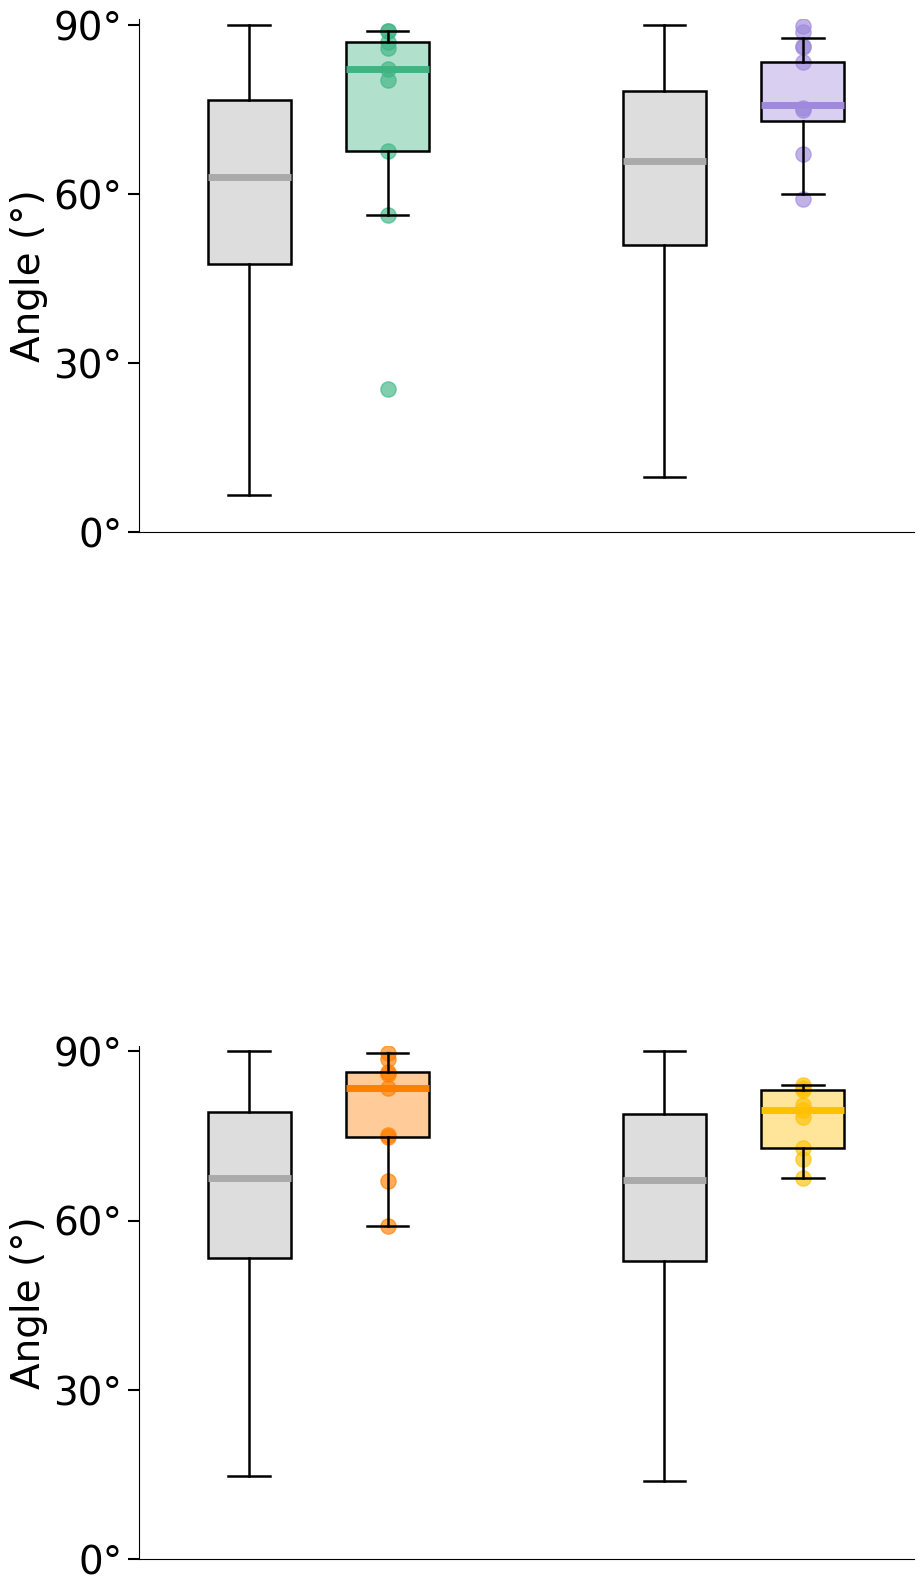

In [129]:
tick_labels = ['Category GNG \nChoice GNG', 'Category LR \nChoice LR','Category GNG \nCategory LR', 'Choice GNG \nChoice LR']

fig,axs = plt.subplots(2,1,figsize=(10,20))
fig.subplots_adjust(hspace=1)

axs[0].set_ylim(0,91)
axs[1].set_ylim(0,91)

axs[0].set_xlim(-0.2,1.2)
axs[1].set_xlim(-0.2,1.2)


axs[0].set_yticks([0,30,60,90],['0°','30°','60°','90°'],fontsize=28)
axs[1].set_yticks([0,30,60,90],['0°','30°','60°','90°'],fontsize=28)

axs[0].set_ylabel('Angle (°)',fontsize=28)
axs[1].set_ylabel('Angle (°)',fontsize=28)

plot1 = [random_angles[0],angles_to_plot[0],random_angles[1],angles_to_plot[1]]
plot2 = [random_angles[2],angles_to_plot[2],random_angles[3],angles_to_plot[3]]

bplot1=axs[0].boxplot(plot1,positions=[0,0.25,0.75,1],patch_artist=True,bootstrap=1000,sym='',widths=.15)

axs[0].scatter(x=[0.25]*len(files),y=angles_to_plot[0],color='#3EB483',alpha=.65,s=120)
axs[0].scatter(x=[1]*len(files),y=angles_to_plot[2],color='#9E89DD',alpha=.65,s=120)

bplot2=axs[1].boxplot(plot2,positions=[0,0.25,0.75,1],patch_artist=True,bootstrap=1000,sym='',widths=.15)

axs[1].scatter(x=[0.25]*len(files),y=angles_to_plot[2],color='#FF7F00',alpha=.65,s=120)
axs[1].scatter(x=[1]*len(files),y=angles_to_plot[3],color='#FFC000',alpha=.65,s=120)

#axs[0].set_xticks([0,0.25,0.75,1],['Permuted','True','Permuted','True'],fontsize=24)
#axs[1].set_xticks([0,0.25,0.75,1],['Permuted','True','Permuted','True'],fontsize=24)

axs[0].set_xticks([])
axs[1].set_xticks([])

colors_intra=[('#AAAAAA', 0.4),('#3EB483', 0.4),('#AAAAAA', 0.4),('#9E89DD', 0.4)]
colors_inter=[('#AAAAAA', 0.4),('#FF7F00', 0.4),('#AAAAAA', 0.4),('#FFC000', 0.4)]

set_color(bplot1,colors_intra)
set_color(bplot2,colors_inter)


plt.savefig('Plots/SVG/reg_angles.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/reg_angles.PNG', dpi = 300,bbox_inches='tight')

## Regression on individual data

In [349]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Parameter grid for regularization
alphas = [(10**(-5))*np.exp(k/5) for k in range(1,100)]

def compute_R2_stats(alpha,X,Y,permutation,nb_fold) :
    pipe = Pipeline([('scaler',  StandardScaler()),('Ridge', Ridge(alpha=alpha,fit_intercept=True))])
        
    kf_permu = KFold(n_splits = nb_fold, shuffle = True, random_state = 42)
    
    output = cross_validate(pipe,X,Y,cv=kf_permu,error_score=0, return_estimator=True)
    scores = output['test_score']
    m = output['estimator'][np.argmax(scores)]
    y_pred = m.predict(X)
    MSE = np.mean((Y-y_pred)**2, axis = 0)
    R2 = 1-MSE    #Y variance is set to 1 after Z-scoring
    
    X_shuffle = X[permutation,:]
    
    output = cross_validate(pipe,X_shuffle,Y,cv=kf_permu,error_score=0, return_estimator=True)
    scores = output['test_score']
    m_shuffle = output['estimator'][np.argmax(scores)]
    y_pred_shuffle = m_shuffle.predict(X_shuffle)
    MSE_shuffle = np.mean((Y-y_pred_shuffle)**2, axis = 0)
    R2_shuffle = 1-MSE_shuffle
    
    cv_R2 = []
    delta_R2 = []
    
    for i in range(np.shape(X)[1]) :
        X_cv = np.copy(X)
        X_cv[:,:i] = X_cv[permutation,:i]
        X_cv[:,i+1:] = X_cv[permutation,i+1:]

        output = cross_validate(pipe,X_cv,Y,cv=kf_permu,error_score=0, return_estimator=True)
        scores = output['test_score']
        
        m_cv = output['estimator'][np.argmax(scores)]
        y_pred_cv = m_cv.predict(X_cv)   
        MSE_cv = np.mean((Y-y_pred_cv)**2, axis = 0)
        R2_cv = 1-MSE_cv
        cv_R2.append(R2_cv - R2_shuffle)
        
        X_delta = np.copy(X)
        X_delta[:,i] = X_delta[permutation,i]
        
        output = cross_validate(pipe,X_delta,Y,cv=kf_permu,error_score=0,return_estimator = True)
        scores = output['test_score']
        
        m_delta = output['estimator'][np.argmax(scores)]
        y_pred_delta = m_delta.predict(X_delta)
        MSE_delta = np.mean((Y-y_pred_delta)**2, axis = 0)
        R2_delta = 1-MSE_delta
        delta_R2.append(R2 - R2_delta)
        
    return np.array(cv_R2),np.array(delta_R2)


def get_best_alpha(X,Y,nb_fold=5, return_grid = False) : 
    pipe = Pipeline([('scaler',  StandardScaler()),('Ridge', Ridge(fit_intercept=True))])    
    
    kf = RepeatedKFold(n_splits = nb_fold,n_repeats = 10)
    

    parameters = {'Ridge__alpha' : alphas}
    
    clf = GridSearchCV(pipe, param_grid = parameters, scoring = 'r2', cv = kf)

    clf.fit(X,Y)
    
    best_alpha = clf.best_params_['Ridge__alpha']
    
    if return_grid :
        return clf, best_alpha
    else :
        return best_alpha
    
    
def compute_regression(X, Y, alpha = None, nb_fold = 5,nb_repeat=10, nb_permu = 0, stats = False, return_permu_models = False) :
    
    if alpha == None :
        best_alpha = get_best_alpha(X,Y,nb_fold=nb_fold)
    
    else :
        best_alpha = alpha
    

    pipe = Pipeline([('scaler',  StandardScaler()),('Ridge', Ridge(alpha=best_alpha,fit_intercept=True))])
    
    rkf = RepeatedKFold(n_splits = nb_fold, n_repeats = nb_repeat)
    output = cross_validate(pipe,X,Y,cv=rkf,error_score=0, return_estimator=True)
    models = output['estimator']
    scores = output['test_score']
        
    if nb_permu > 0 :
        N = np.shape(X)[0]
        
        delta_R2s = []
        cv_R2s = []
        permu_models = []
        for p in tqdm(range(nb_permu),leave=False) :
            
            permutation = np.random.permutation(N)
            
            if stats :
                cv_R2, delta_R2 = compute_R2_stats(best_alpha,X,Y,permutation,nb_fold)
                delta_R2s.append(delta_R2)
                cv_R2s.append(cv_R2)
            
            if return_permu_models :
                permutation = np.random.permutation(N)
                X_shuffle = X[permutation,:]
        
                pipe = Pipeline([('scaler',  StandardScaler()),('Ridge', Ridge(alpha=best_alpha,fit_intercept=True))])
                    
                kf_permu = KFold(n_splits = nb_fold, shuffle=True)
                output = cross_validate(pipe,X_shuffle,Y,cv=kf_permu,error_score=0, return_estimator=True)
                scores = output['test_score']
                ms_permu = output['estimator']
                permu_models.append([ms_permu[k]['Ridge'] for k in range(nb_fold)])
        
        
        if stats&return_permu_models :
            return models,scores, permu_models, np.array(delta_R2s), np.array(cv_R2s)
        
        if stats : 
            return models,scores, np.array(delta_R2s), np.array(cv_R2s)
        
        if return_permu_models :
            return models,scores, permu_models
        

    return models,scores

In [430]:
neuron_per_animal = []
for file in files :
    neuron_per_animal.append(len(data_full[file]['Spike rate'][0]))

def split_mat(M) :
    # Return selectivity matrix for each animal
    M_splitted = []
    c=0
    for i in range(len(neuron_per_animal)) :
        M_splitted.append(M[:,c:c+neuron_per_animal[i]])
        c+=neuron_per_animal[i]

    return M_splitted

pca1_s = split_mat(pca1.components_)
pca2_s = split_mat(pca2.components_)

def compute_angles(S):
    all_angles = [[[] for _ in range(6)] for _ in range(6)]
    for i in range(6) :
        all_angles[i][i].append(0)
        for j in range(i+1,6) :
            all_angles[i][j].append(angle_between(S[i,:],S[j,:]))
            all_angles[j][i].append(angle_between(S[i,:],S[j,:]))
            
    return np.array(all_angles)


def produce_X(d) : 
    d['Motor action'] = (d['Choice'] != 0)
    d['Reward'] = np.nan_to_num(d['Reward'])
    
    regressor_labels = ['Category','Choice','Motor action','Reward','Context','Category G/NG','Choice G/NG', 'Category L/R','Choice L/R','Motor action L/R']
    
    simple_regressor = d[['Category ID', 'Choice','Motor action','Context','Reward']].to_numpy()
    simple_regressor = standardize(simple_regressor)
    interactions = pd.concat((simple_regressor[:,0]*(d['Context'] == 0), simple_regressor[:,1]*(d['Context'] == 0),\
                              simple_regressor[:,0]*(d['Context'] == 1), simple_regressor[:,1]*(d['Context'] == 1), simple_regressor[:,2]*(d['Context'] == 1)),axis=1)
    
    interactions = interactions.to_numpy()
    
    X = np.concatenate((interactions,simple_regressor[:,3:]),axis=1)
    
    X = standardize(X)

    return X
    

In [456]:
cvR2_all = []
deltaR2_all = []
reg_all = []
scores_all = []
permu_all = []
for f in range(len(files)) :
    d = data_full[files[f]]
    
    pca1_i = pca1_s[f]
    

    X = produce_X(d)

    M = np.stack(d['Spike rate'])
    M = standardize(M)
    M = np.dot(M, pca1_i.T)
    
    inverse_transform = True
    if inverse_transform :
        Y = standardize(np.dot(M, pca1_i))
    else :
        Y = standardize(M)

    reg, scores, permu_reg, deltaR2, cvR2  = compute_regression(X,Y, nb_fold = 5, nb_permu = 10, stats = True, return_permu_models=True)


    cvR2_all.append(cvR2)
    deltaR2_all.append(deltaR2)
    reg_all.append(reg)
    scores_all.append(scores)
    permu_all.append(permu_reg)



cvR2_all = np.concatenate(cvR2_all,axis=2)
deltaR2_all = np.concatenate(deltaR2_all,axis=2)


permu_all = np.array(permu_all)
permu_all = np.resize(permu_all, (np.shape(permu_all)[0],np.shape(permu_all)[1]*np.shape(permu_all)[2]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

"\nplt.savefig('Plots/PNG/Var_cvR2.PNG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/SVG/Var_cvR2.SVG', dpi = 300,bbox_inches='tight')\n"

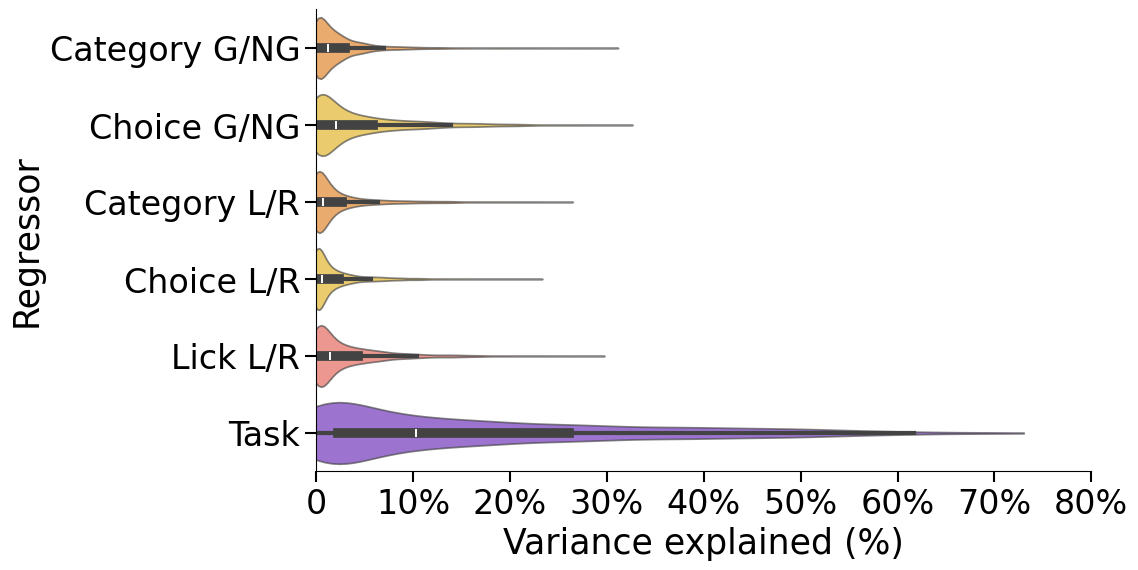

In [426]:
plt.figure(figsize=(10,6))


ax = plt.gca()

plot_labels = ['Category G/NG','Choice G/NG','Category L/R','Choice L/R','Lick L/R','Task']

df_label = []
for i in range(len(plot_labels)) :
    df_label += [plot_labels[i]]*np.shape(cvR2_all)[2]

['Category G/NG','Choice G/NG','Category L/R','Choice L/R','Lick L/R','Task']

#df_var = pd.DataFrame({'Variance':np.mean((cvR2_all[:,:-1,:]+deltaR2_all[:,:-1,:])/2,axis=0).reshape(-1),'Regressor':df_label})
df_var = pd.DataFrame({'Variance':np.mean(deltaR2_all[:,:-1,:],axis=0).reshape(-1),'Regressor':df_label})
colors_plot=['#FF7F00','#FFC000','#FF7F00','#FFC000','#FB4D3D','#6510CE']

sns.violinplot(data = df_var,x='Variance',y='Regressor',alpha=0.65,ax=ax,palette=colors_plot,inner_kws={'box_width':7, 'whis_width':3},width=0.8,cut=0)


plt.yticks([0,1,2,3,4,5],plot_labels)

plt.xlabel('Variance explained (%)')
plt.xlim(0,0.8)
#plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20%','40%','60%','80%','100%'])
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],['0','10%','20%','30%','40%','50%','60%','70%','80%'])


"""
plt.savefig('Plots/PNG/Var_cvR2.PNG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/SVG/Var_cvR2.SVG', dpi = 300,bbox_inches='tight')
"""

#### Angles on individual regressions

In [458]:
S_all = []

for f in range(len(files)) :
    reg_i = reg_all[f]
    scores_i = scores_all[f]
    m_i = reg_i[np.argmax(scores_i)]
    S_all.append(m_i['Ridge'].coef_.T)

In [460]:
angles_indiv = []
for f in range(len(files)):
    angles_indiv.append(compute_angles(S_all[f]@pca1_s[f].T))

angles_indiv = np.squeeze(np.array(angles_indiv))

In [462]:
S_permu_all = [[permu_all[f,p].coef_.T for p in range(np.shape(permu_all)[1])] for f in range(len(files))]

angles_permu = []
for f in range(len(files)) :
    sp_i = S_permu_all[f]
    for sp in sp_i:
        angles_permu.append(compute_angles(sp@pca1_s[f].T))

angles_permu = np.squeeze(np.array(angles_permu))

### Across time

In [432]:
cvR2_all_t = []
deltaR2_all_t = []
for f in range(len(files)) :
    #idx = 0
    
    d = data_full[files[f]]
    
    pca2_i = pca2_s[f]
    
    
    D = np.stack(d['Traj'])
    
    X = produce_X(d)
    
    reg_t = []
    scores_t = []
    deltaR2_t = []
    cvR2_t = []
    for t in tqdm(range(np.shape(D)[1])) :
        M = D[:,t,:]
        M = standardize(M)
        M = np.dot(M, pca2_i.T)
        

        inverse_transform = True
        if inverse_transform :
            Y = standardize(np.dot(M, pca2_i))
        else :
            Y = standardize(M)
        
        reg, scores, deltaR2, cvR2  = compute_regression(X,Y, alpha=1, nb_fold = 5, nb_permu = 20, stats = True, return_permu_models=False)
    
        reg_t.append(reg)
        scores_t.append(scores)
        deltaR2_t.append(deltaR2)
        cvR2_t.append(cvR2)


    reg_t = np.array(reg_t)
    scores_t = np.array(scores_t)
    deltaR2_t = np.array(deltaR2_t)
    cvR2_t = np.array(cvR2_t)

    cvR2_all_t.append(cvR2_t)
    deltaR2_all_t.append(deltaR2_t)

cvR2_all_t = np.concatenate(cvR2_all_t,axis=3)
deltaR2_all_t = np.concatenate(deltaR2_all_t,axis=3)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [339]:
np.shape(cvR2_all_t)

(18, 5, 7, 2389)

"\nplt.savefig('Plots/PNG/cvR2_GNG_t.PNG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/SVG/cvR2_GNG_t.SVG', dpi = 300,bbox_inches='tight')\n"

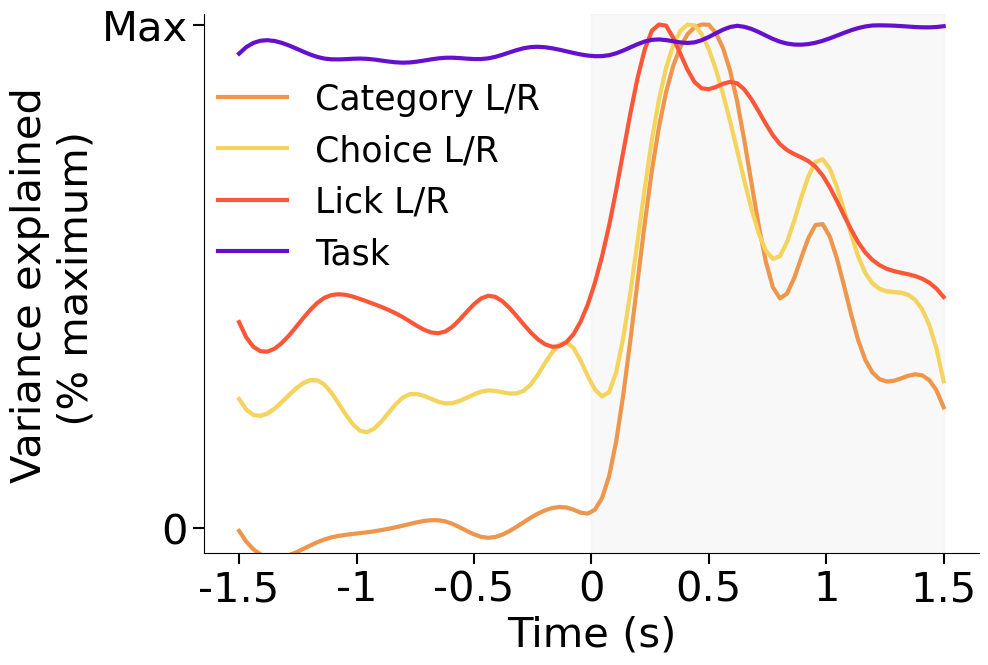

In [448]:
plt.figure(figsize=(10,7))

plot_labels = ['Category G/NG','Choice G/NG','Category L/R','Choice L/R','Lick L/R','Task']

colors = ['#ee964b','#f4d35e','#ee964b','#f4d35e','#f95738','#6510CE']

T = np.shape(cvR2_all_t)[0]

for k in [2,3,4,5] :
    values = [np.mean(cvR2_all_t[:,i,k,:], axis = 1) for i in range(np.shape(cvR2_all_t)[1])]
    
    for v in range(len(values)) :
        values[v] = values[v]/np.max(values[v])
    
    values = np.array(values)
    values_std = np.array([np.std(values[:,i], axis = 0) for i in range(np.shape(values)[1])])
    values_error = values_std*1.96/np.sqrt(np.shape(cvR2_all_t)[-1])
    values_mean = np.array([np.mean(values[:,i], axis = 0) for i in range(np.shape(values)[1])])
    
    T_smooth, values_mean = smooth(range(T),values_mean,100)
    T_smooth, values_error = smooth(range(T),values_error,100)

    for v in range(len(values_mean)) :
        values_mean[v] = values_mean[v]/np.max(values_mean)

    #max_val = np.max(values)
    plt.plot(T_smooth,values_mean,label=plot_labels[k],c=colors[k],linewidth=3)
    plt.fill_between(T_smooth,values_mean - values_error, values_mean + values_error, color = colors[k], alpha = 0.25)
    
plt.xlabel('Time (s)',fontsize=30)
plt.ylim((-0.05,1.02))

plt.xticks(np.linspace(0,T-1,7),[-1.5,-1,-0.5,0,0.5,1,1.5],fontsize=30)
plt.yticks([0,1],['0','Max'],fontsize=30)
#plt.ylabel(r'$cvR^2$' + '\n (% maximum)',fontsize=30)
plt.ylabel(r'Variance explained' + '\n (% maximum)',fontsize=30)
plt.legend(frameon=False,loc=(0,0.5))

#plt.axvline(4.5,color='black')
plt.fill_between([T//2-1/2,T-1],-0.05,1.02,color='grey',alpha=0.05)


"""
plt.savefig('Plots/PNG/cvR2_GNG_t.PNG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/SVG/cvR2_GNG_t.SVG', dpi = 300,bbox_inches='tight')
"""